# Seamless Python Interoperability


In [0]:
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"

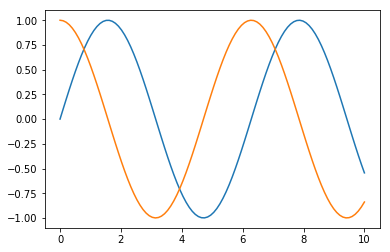

None


In [2]:
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

IPythonDisplay.shell.enable_matplotlib("inline")

let x = np.linspace(0, 10, 100)

plt.plot(x, np.sin(x))
plt.plot(x, np.cos(x))

plt.show()

# Demo: RL with OpenAI Gym


In [0]:
let gym = Python.import("gym")

/// Model parameters and hyper parameters.
let hiddenSize = 128
let batchSize = 16
/// Controls the amount of good/long episodes to retain for training.
let percentile = 70

In [0]:
/// A simple two layer dense net.
struct Net: Layer {
    var l1, l2: Dense<Float>

    init(observationSize: Int, hiddenSize: Int, actionCount: Int) {
        l1 = Dense<Float>(inputSize: observationSize, outputSize: hiddenSize, activation: relu)
        l2 = Dense<Float>(inputSize: hiddenSize, outputSize: actionCount)
    }

    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: l1, l2)
    }
}

In [0]:
/// An episode is a list of steps, where each step records the observation from
/// env and the action taken. They will serve respectively as the input and
/// target (label) of the neural net training.
struct Episode {
    struct Step {
        let observation: Tensor<Float>
        let action: Int32
    }

    let steps: [Step]
    let reward: Float
}

/// Filters out bad/short episodes before we feed them as neural net training data.
func filteringBatch(
    episodes: [Episode],
    actionCount: Int
) -> (input: Tensor<Float>,
      target: Tensor<Float>,
      episodeCount: Int,
      meanReward: Float) {
    let rewards = episodes.map { $0.reward }
    let rewardBound = Float(np.percentile(rewards, percentile))!
    print("rewardBound = \(rewardBound)")

    var input = Tensor<Float>(0.0)
    var target = Tensor<Float>(0.0)
    var totalReward: Float = 0.0

    var retainedEpisodeCount = 0
    for episode in episodes {
        if episode.reward < rewardBound {
            continue
        }

        let observationTensor = Tensor<Float>(episode.steps.map { $0.observation })
        let actionTensor = Tensor<Int32>(episode.steps.map { $0.action })
        let oneHotLabels = Tensor<Float>(oneHotAtIndices: actionTensor, depth: actionCount)

        if retainedEpisodeCount == 0 {
            input = observationTensor
            target = oneHotLabels
        } else {
            input = input.concatenated(with: observationTensor)
            target = target.concatenated(with: oneHotLabels)
        }

        totalReward += episode.reward
        retainedEpisodeCount += 1
    }
  
    return (input, target, retainedEpisodeCount, totalReward / Float(retainedEpisodeCount))
}

In [0]:
func nextBatch(env: PythonObject,
               net: Net,
               batchSize: Int,
               actionCount: Int
) -> [Episode] {
    var observationNumpy = env.reset()

    var episodes = [Episode]()

    withLearningPhase(.inference) {  
        // Build up a batch of observations and actions.
        for _ in 0..<batchSize {
            var steps = [Episode.Step]()
            var episodeReward: Float = 0.0

            while true {
                let observationPython = Tensor<Double>(numpy: observationNumpy)!
                let actionProbabilities =
                    softmax(net(Tensor(observationPython).reshaped(to: [1, 4])))
                let actionProbabilitiesPython = actionProbabilities[0].makeNumpyArray()
                let len = Python.len(actionProbabilitiesPython)
                assert(actionCount == Int(len))
      
                let actionPython = np.random.choice(len, p: actionProbabilitiesPython)
                let (nextObservation, reward, isDone, _) = env.step(actionPython).tuple4

                steps.append(Episode.Step(observation: Tensor<Float>(observationPython),
                                          action: Int32(actionPython)!))

                episodeReward += Float(reward)!

                if isDone == true {
                    episodes.append(Episode(steps: steps, reward: episodeReward))
                    observationNumpy = env.reset()
                    break
                } else {
                    observationNumpy = nextObservation
                }
            }
        }
    }
    return episodes

}

In [0]:
let env = gym.make("CartPole-v0")
let observationSize = Int(env.observation_space.shape[0])!
let actionCount = Int(env.action_space.n)!

var meanRewards = [Float]()

var net = Net(
    observationSize: observationSize,
    hiddenSize: hiddenSize,
    actionCount: actionCount)
let optimizer = Adam(for: net, learningRate: 0.01)
Context.local.learningPhase = .training

for batchIndex in 0... {
    print("Processing mini batch \(batchIndex)")
  
    let episodes = nextBatch(
        env: env, net: net, batchSize: batchSize, actionCount: actionCount)
    let (input, target, episodeCount, meanReward) = 
        filteringBatch(episodes: episodes, actionCount: actionCount)

    let gradients = gradient(at: net) { model -> Tensor<Float> in
        let logits = model(input)
        let loss = softmaxCrossEntropy(logits: logits, oneHotLabels: target)
        print("loss is \(loss)")
        return loss
    }
    optimizer.update(&net, along: gradients)

    print("It has episode count \(episodeCount) and mean reward \(meanReward)")
    meanRewards.append(meanReward)

    if meanReward > 199 {
        print("Solved")
        break
    }
}

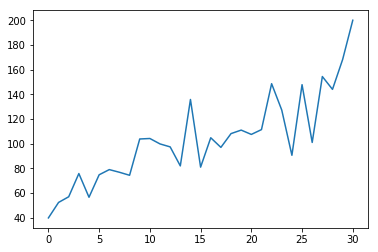

None


In [0]:
plt.plot(meanRewards)
plt.show()